In [1]:
## IMPORT PACKAGES

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
## DATSET EXTENSION 

In [4]:
from torchvision.datasets import MNIST
import numpy as np
class MyDataset(MNIST):

    def __init__(self, *args, **kwargs):
        super(MyDataset, self).__init__(*args, **kwargs)
        
    def __getitem__(self, index):
        img, target = super(self.__class__, self).__getitem__(index)
        random_number = np.random.randint(low=0, high=10)
        return (img, random_number), (target, target + random_number)

In [5]:
## CUSTOMIZED MNIST DATASET

In [6]:

train_dataset = MyDataset('../data',train=True, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
test_dataset = MyDataset('../data',train=False, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MyDataset/raw/train-images-idx3-ubyte.gz to ../data/MyDataset/raw




Extracting ../data/MyDataset/raw/train-labels-idx1-ubyte.gz to ../data/MyDataset/raw




Extracting ../data/MyDataset/raw/t10k-images-idx3-ubyte.gz to ../data/MyDataset/raw




Extracting ../data/MyDataset/raw/t10k-labels-idx1-ubyte.gz to ../data/MyDataset/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
## NETWORK STRUCTURE

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.num_classes = 10
        #IMAGE 1X1X28 => 1X1X10 
        self.input_block = nn.Sequential(
        #INPUT 28X28X1 >>CONV 3X3X1X16 >>26X26X16
        nn.Conv2d(1, 16, 3, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.1),


        #INPUT 26X26X16 >>CONV 3X3X16X32 >>24X24X32
        nn.Conv2d(16, 32, 3, bias=False), 
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.1),
        )
          # translation layer

        self.trans1 = nn.Sequential(
        #24X24x32 >>CONV 1X1X32X8 >>24X24X8
        nn.Conv2d(32, 8, 1, bias=False), 
        nn.ReLU(),
        #24X24x8 >>MAXPOOL (2,2) >>12X12X8
        nn.MaxPool2d(2, 2),
        )
        self.conv_block = nn.Sequential(
        #12X12x8 >>CONV 3X3X8X16 PAD=1 >>12X12X16
        nn.Conv2d(8, 16, 3,padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.1),

        #12X12x16 >>CONV 3X3X16X32 >>10X10X32

        nn.Conv2d(16, 32, 3, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.1),

        )
                # translation layer
        self.trans2 = nn.Sequential(
        #10X10x32 >>CONV 1X1X32X8 >>10X10X8
        nn.Conv2d(32, 8, 1, bias=False), 
        nn.ReLU(),
        #10X10x8 >>MAXPOOL (2,2) >>5X5X8
        nn.MaxPool2d(2, 2),
        )
        self.conv_block2 = nn.Sequential(
        #5X5X8 >>CONV 3X3X8X16 PAD=1 >>5X5X16
        nn.Conv2d(8, 16, 3,padding=1,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(0.1),  
        #5X5X16 >>CONV 3X3X8X32 PAD=0 >>3X3X32
        nn.Conv2d(16, 32, 3,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Dropout2d(0.1),

        )


        self.avg_pool = nn.Sequential(
        #3X3X32 >>CONV 1X1X32X10  >>3X3X10
        nn.Conv2d(32, 10, 1, bias=False),
        #3X3X10 >>AVG pool(3X3) >>1X1X10
        nn.AvgPool2d(3))


        self.adder_layer1 = nn.Sequential(nn.Linear(in_features=10+10, out_features=60, bias=False),nn.BatchNorm1d(60),nn.ReLU(),nn.Dropout(0.1)) #10 from image #10 from one hot encode 
        self.adder_layer2 = nn.Sequential(nn.Linear(in_features=60, out_features=60, bias=False),nn.BatchNorm1d(60),nn.ReLU(),nn.Dropout(0.1))
        self.adder_layer3 = nn.Sequential(nn.Linear(in_features=60, out_features=10, bias=False))
        self.adder_layer4 = nn.Sequential(nn.Linear(in_features=60, out_features=19, bias=False))


    def forward(self, x, y):
        y = F.one_hot(y, num_classes=self.num_classes)
        images=x
        x = self.input_block(images)
        x = self.trans1(x)
        x = self.conv_block(x)
        x = self.trans2(x)
        x = self.conv_block2(x)
        x = self.avg_pool(x)
        x = x.view(-1, 10)
        y = torch.cat([x, y], dim=-1)
        y = self.adder_layer1(y)
        y = self.adder_layer2(y)

        images_out=self.adder_layer3(y)
        digits_out=self.adder_layer4(y)

        return F.log_softmax(images_out), F.log_softmax(digits_out)
       





In [9]:

# class Net(nn.Module):
#     def __init__(self, num_classes):
#         super(Net, self).__init__()
#         self.num_classes = num_classes
#         self.conv1 = nn.Conv2d(1, 8, 3, padding=1) #input -? OUtput? RF
#         self.conv2 = nn.Sequential(nn.Conv2d(8, 8, 3, padding=1),nn.BatchNorm2d(8))
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
#         self.conv4 = nn.Sequential(nn.Conv2d(8, 16, 3, padding=1),nn.BatchNorm2d(16),nn.Dropout(0.23))
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv5 = nn.Conv2d(16, 32, 3)
#         self.conv6 = nn.Conv2d(32, 32, 3)
#         self.conv7 = nn.Conv2d(32, 10, 3)
#         self.adder_layer1 = nn.Sequential(nn.Linear(in_features=20, out_features=60, bias=False),nn.BatchNorm1d(60),nn.ReLU(),nn.Dropout(0.1))
#         self.adder_layer2 = nn.Sequential(nn.Linear(in_features=60, out_features=60, bias=False),nn.BatchNorm1d(60),nn.ReLU(),nn.Dropout(0.1))
#         self.adder_layer3 = nn.Sequential(nn.Linear(in_features=60, out_features=19, bias=False))


#     def forward(self, x, y):
#         y = F.one_hot(y, num_classes=self.num_classes)
#         x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
#         x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
#         x = F.relu(self.conv6(F.relu(self.conv5(x))))
#         x = self.conv7(x)
#         x = x.view(-1, 10)
#         y = torch.cat([x, y], dim=-1)
#         y = self.adder_layer1(y)
#         y = self.adder_layer2(y)
#         y = self.adder_layer3(y)
#         return F.log_softmax(x), F.log_softmax(y)

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

In [11]:
## MNIST DATA LOADER

In [12]:
torch.manual_seed(1)
batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)

In [13]:
## TRAIN TEST 

In [14]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  correct = 0
  digits_correct=0
  sums_correct=0
  processed = 0
  #for batch_idx, batch in enumerate(pbar):
  for data,target in train_loader:
    #data,target=batch 
    # get samples
    (mnist_x, rand_num) = data
    (mnist_y, final_y) = target
    mnist_x, rand_num, mnist_y, final_y  = mnist_x.to(device), rand_num.to(device), mnist_y.to(device), final_y.to(device)

    optimizer.zero_grad()
    mnist_pred, final_pred = model(mnist_x, rand_num)
    # mnist_loss = F.nll_loss(mnist_pred, mnist_y)
    # adder_loss = F.nll_loss(final_pred, final_y)
    mnist_loss = F.cross_entropy(mnist_pred, mnist_y)
    adder_loss = F.cross_entropy(final_pred, final_y)
    loss = mnist_loss + adder_loss
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    digits_correct += mnist_pred.argmax(1).eq(mnist_y).sum().item()
    sums_correct += final_pred.argmax(1).eq(final_y).sum().item()

  train_acc_image_epoch=round(100. * digits_correct / len(train_loader.dataset),2)
  adder_acc_image_epoch=round(100. * sums_correct / len(train_loader.dataset),2)
  train_loss = loss/len(train_loader.dataset)
  #print(digits_correct,sums_correct,train_acc_image_epoch,adder_acc_image_epoch)

  print("[TRAIN]: => loss {0}, total_correct_digits {1}, total_correct_sums {2} ,[image_accuracy]={3} , [adder_accuracy]={4} ".format(train_loss, digits_correct,sums_correct,train_acc_image_epoch,adder_acc_image_epoch))
  return train_loss,train_acc_image_epoch,adder_acc_image_epoch

In [15]:
#from tqdm import tqdm
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     pbar = tqdm(train_loader)
#     for batch_idx, (data, target) in enumerate(pbar):
#         (mnist_x, rand_num) = data
#         (mnist_y, final_y) = target
#         mnist_x, rand_num, mnist_y, final_y  = mnist_x.to(device), rand_num.to(device), mnist_y.to(device), final_y.to(device)
#         optimizer.zero_grad()
#         mnist_pred, final_pred = model(mnist_x, rand_num)
#         mnist_loss = F.nll_loss(mnist_pred, mnist_y)
#         adder_loss = F.nll_loss(final_pred, final_y)
#         loss = mnist_loss + adder_loss
#         loss.backward()
#         optimizer.step()
#         pbar.set_description(desc= f'loss={loss.item()}, MNIST_LOSS={mnist_loss.item()}, ADDER_LOSS={adder_loss.item()}, batch_id={batch_idx}')
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    mnist_correct = 0
    adder_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            (mnist_x, rand_num) = data
            (mnist_y, final_y) = target
            mnist_x, rand_num, mnist_y, final_y  = mnist_x.to(device), rand_num.to(device), mnist_y.to(device), final_y.to(device)
            mnist_pred, final_pred = model(mnist_x, rand_num)
            mnist_loss = F.nll_loss(mnist_pred, mnist_y)
            adder_loss = F.nll_loss(final_pred, final_y)
            loss = mnist_loss + adder_loss
            mnist_pred = torch.argmax(mnist_pred, dim=1)
            final_pred = torch.argmax(final_pred, dim=1)
            test_loss += loss.item()  # sum up batch loss
            mnist_correct += mnist_pred.eq(mnist_y.view_as(mnist_pred)).sum().item()
            adder_correct += final_pred.eq(final_y.view_as(final_pred)).sum().item()


    test_loss /= len(test_loader.dataset)
    test_acc_image_epoch=round(100. * mnist_correct / len(test_loader.dataset),2)
    adder_acc_image_epoch=round(100. * adder_correct / len(test_loader.dataset),2)

    print("[TEST]:  => loss {0}, total_correct_digits {1}, total_correct_sums {2} ,[image_accuracy]={3} , [adder_accuracy]={4} ".format(test_loss, mnist_correct,adder_correct,test_acc_image_epoch,adder_acc_image_epoch))
    print()
    return test_loss,test_acc_image_epoch,adder_acc_image_epoch


In [16]:
## tRAIN 

In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)

# for epoch in range(1, 5):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)

EPOCHS = 30
train_loss_per_epoch=[]
train_image_acc_per_epoch=[]
train_adder_accuracy_per_epoch=[]
test_loss_per_epoch=[]
test_image_acc_per_epoch=[]
test_adder_accuracy_per_epoch=[]


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch_loss,train_image_accuracy,train_adder_accuracy=train(model, device, train_loader, optimizer, epoch)

    train_loss_per_epoch.append(train_epoch_loss)
    train_image_acc_per_epoch.append(train_image_accuracy)
    train_adder_accuracy_per_epoch.append(train_adder_accuracy)

    test_epoch_loss,test_image_accuracy,test_adder_accuracy=test(model, device, test_loader)

    test_loss_per_epoch.append(test_epoch_loss)
    test_image_acc_per_epoch.append(test_image_accuracy)
    test_adder_accuracy_per_epoch.append(test_adder_accuracy)

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[TRAIN]: => loss 3.181002466590144e-05, total_correct_digits 43043, total_correct_sums 19143 ,[image_accuracy]=71.74 , [adder_accuracy]=31.91 
[TEST]:  => loss 0.005468686771392822, total_correct_digits 9621, total_correct_sums 8696 ,[image_accuracy]=96.21 , [adder_accuracy]=86.96 

EPOCH: 1
[TRAIN]: => loss 1.062575483956607e-05, total_correct_digits 56191, total_correct_sums 48759 ,[image_accuracy]=93.65 , [adder_accuracy]=81.27 
[TEST]:  => loss 0.0010679741784930228, total_correct_digits 9792, total_correct_sums 9772 ,[image_accuracy]=97.92 , [adder_accuracy]=97.72 

EPOCH: 2
[TRAIN]: => loss 9.959942872228567e-06, total_correct_digits 57379, total_correct_sums 54993 ,[image_accuracy]=95.63 , [adder_accuracy]=91.66 
[TEST]:  => loss 0.0005570014610886574, total_correct_digits 9838, total_correct_sums 9828 ,[image_accuracy]=98.38 , [adder_accuracy]=98.28 

EPOCH: 3
[TRAIN]: => loss 4.842951966566034e-06, total_correct_digits 57948, total_correct_sums 56503 ,[image_accuracy]=96.58 , 

In [18]:
## PLOT 

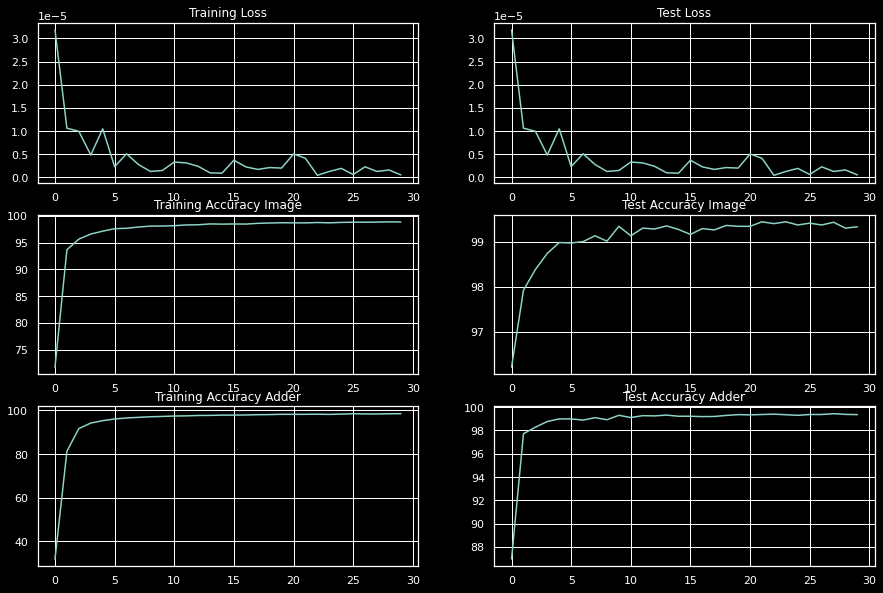

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(3,2,figsize=(15,10))
axs[0, 0].plot(train_loss_per_epoch)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(train_loss_per_epoch)
axs[0, 1].set_title("Test Loss")
axs[1, 0].plot(train_image_acc_per_epoch)
axs[1, 0].set_title("Training Accuracy Image")
axs[1, 1].plot(test_image_acc_per_epoch)
axs[1, 1].set_title("Test Accuracy Image")
axs[2, 0].plot(train_adder_accuracy_per_epoch)
axs[2, 0].set_title("Training Accuracy Adder")
axs[2, 1].plot(test_adder_accuracy_per_epoch)
axs[2, 1].set_title("Test Accuracy Adder")
plt.show()

In [20]:

def infer_and_plot_output(sample_data, model):
    (mnist_img, adder_num), (mnist_target, adder_target) = sample_data
    
    with torch.no_grad():
        mnist_pred, adder_pred = model(mnist_img, adder_num)
        mnist_pred, adder_pred = torch.argmax(mnist_pred, dim=1), torch.argmax(adder_pred, dim=1)

    num_images = 25
    fig = plt.figure(figsize=(12, 15))

    assert len(mnist_img[0] >= 25), "need atleast 25 images in `sample_data`"

    fig.suptitle('MNIST Adder')

    for idx in range(0, 25):

        image = mnist_img[idx].cpu().numpy()
        add_num = adder_num[idx].cpu().item()
        image_target = mnist_target[idx].cpu().item()
        add_target = adder_target[idx].cpu().item()
        image_pred = mnist_pred[idx].cpu().item()
        add_pred = adder_pred[idx].cpu().item()

        isvalid = (image_target == image_pred) and (add_target == add_pred)
        isvalid = str(isvalid).upper()

        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.imshow(mnist_img[idx].squeeze())
        ax.set_title(f'target: {image_target} + {add_num} = {add_target}\npred: {image_pred} + {add_num} = {add_pred}\nValid: {isvalid}')

    plt.show()

In [21]:
plotting_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=True, **kwargs)
data = iter(plotting_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


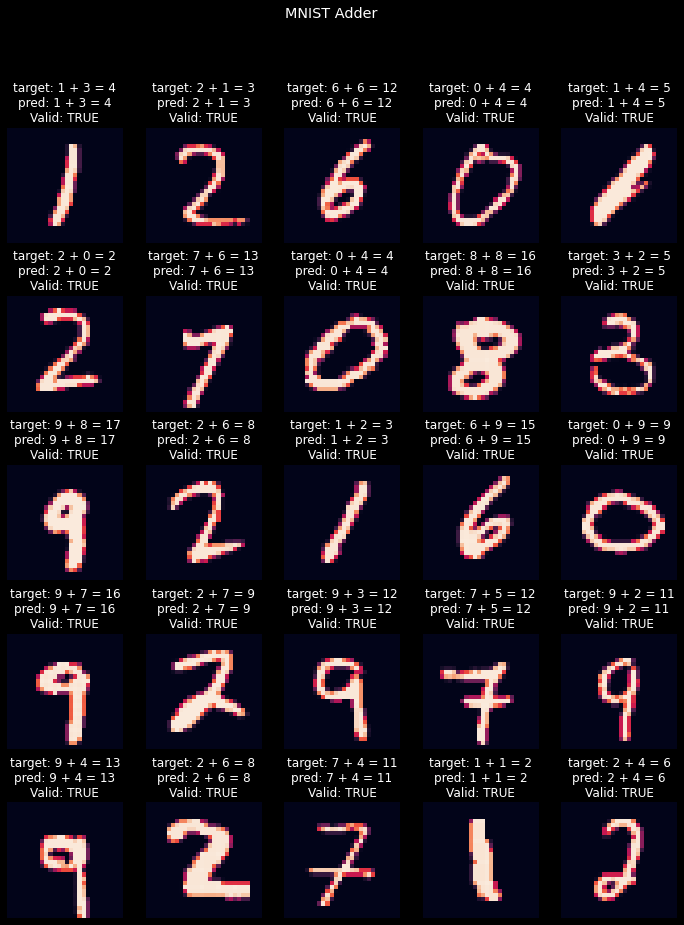

In [22]:
infer_and_plot_output(next(data),model.to('cpu'))